<a href="https://colab.research.google.com/github/Sachin270/CMLAssignment2/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting over user google drive

In [34]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [35]:
!ls /content/drive/'MyDrive'/'Colab Notebooks'/

'Copy of Assignment2 (1).ipynb'   Image_classification_data.zip
'Copy of Assignment2.ipynb'	  model_VGG_3
'Copy of Untitled8 (1).ipynb'	  Untitled0.ipynb
'Copy of Untitled8.ipynb'


In [ ]:
!cp /content/drive/'MyDrive'/'Colab Notebooks'/'Image_classification_data.zip' .
!unzip -q -o 'Image_classification_data.zip'
!rm 'Image_classification_data.zip'
!ls

# **Importing the required dependencies**

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.patches as mpatches

# **Importing Data**

In [38]:
data = pd.read_csv('./data_labels_mainData.csv')
OUTPUT_CLASSES = 4
data.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

# **Exploratory Data Analysis**

In [39]:
data.groupby('cellTypeName').agg('count')

,InstanceID,patientID,ImageName,cellType,isCancerous
cellTypeName,,,,,
epithelial,4079,4079,4079,4079,4079
fibroblast,1888,1888,1888,1888,1888
inflammatory,2543,2543,2543,2543,2543
others,1386,1386,1386,1386,1386


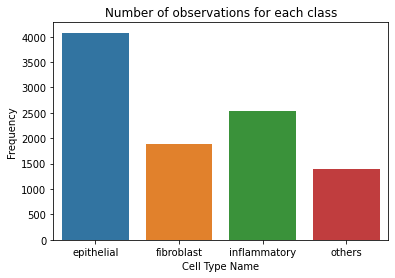

In [40]:
sns.barplot(x=data.groupby('cellTypeName').agg('count').index, 
            y='cellType',
            data=data.groupby('cellTypeName').agg('count'))
plt.title("Number of observations for each class")
plt.xlabel("Cell Type Name")
plt.ylabel("Frequency")
plt.show()

In [41]:
data.groupby('isCancerous').agg('count')

,InstanceID,patientID,ImageName,cellTypeName,cellType
isCancerous,,,,,
0,5817,5817,5817,5817,5817
1,4079,4079,4079,4079,4079


In [42]:
data.groupby(['cellTypeName', 'isCancerous']).agg('count')

,,InstanceID,patientID,ImageName,cellType
cellTypeName,isCancerous,,,,
epithelial,1,4079,4079,4079,4079
fibroblast,0,1888,1888,1888,1888
inflammatory,0,2543,2543,2543,2543
others,0,1386,1386,1386,1386


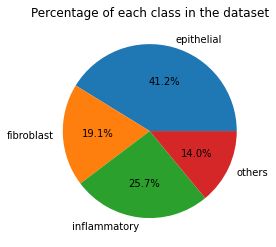

In [43]:
data.groupby('cellTypeName').agg('count').cellType.plot.pie(autopct="%.1f%%")
plt.title("Percentage of each class in the dataset")
plt.ylabel("")
plt.show()

In [44]:
extraData = pd.read_csv('data_labels_extraData.csv')
extraData.columns

Index(['InstanceID', 'patientID', 'ImageName', 'isCancerous'], dtype='object')

In [45]:
mergedData = pd.concat([data[["InstanceID", "patientID", "ImageName", "isCancerous"]], extraData])

In [46]:
mergedData.groupby('isCancerous').agg('count')

,InstanceID,patientID,ImageName
isCancerous,,,
0,13211,13211,13211
1,7069,7069,7069


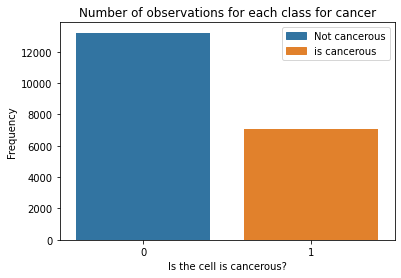

In [47]:
sns.barplot(x=mergedData.groupby('isCancerous').agg('count').index, 
            y='ImageName', 
            data=mergedData.groupby('isCancerous').agg('count'))
plt.title("Number of observations for each class for cancer")
plt.xlabel("Is the cell is cancerous?")
plt.ylabel("Frequency")
red_patch = mpatches.Patch(color='#3274a1', label='Not cancerous')
blue_patch = mpatches.Patch(color='#e1812c', label='is cancerous')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

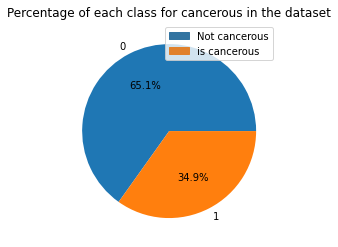

In [48]:
mergedData.groupby('isCancerous').agg('count').ImageName.plot.pie(autopct="%.1f%%")
plt.title("Percentage of each class for cancerous in the dataset")
red_patch = mpatches.Patch(color='#3274a1', label='Not cancerous')
blue_patch = mpatches.Patch(color='#e1812c', label='is cancerous')
plt.legend(handles=[red_patch, blue_patch])
plt.ylabel("")
plt.show()

# **Train Test Split**
* Classification model to predict wether cell is cancerous or not.

* As we have two classes i.e 1 and 0, so `OUTPUT_CLASSES` is set to `2`.

* Main data was merged with extra data to help make the model to predict Cancerous cells and to use transfer learning to predict cellType which is discussed later. 

* On the merged data, Train test split was performed for training the model 80% (12168 observations) data was used and 20% (4056 observations) data was kept for testing and 25% (4056 observations) for validation in predicting Cancerous cells. 

* Similar splitting was used for the model to predict `CellType`. 

In [49]:
OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(mergedData, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

train_data['Class'] = train_data['isCancerous'].astype('str')
val_data['Class'] = val_data['isCancerous'].astype('str')

Train data : 12168, Val Data: 4056, Test Data: 4056


# **Data Preprocessing**

* Data augmentation was performed to increase the model’s accuracy because we do not have enough data for Neural Networks. 

* We have augmented the data by:

  1.   Rescaling the image which multiplies every pixel in the preprocessing image.
  2.   Setting the data format to channels_last mode which means that the images should have shape (samples, channels, height, width).
  3. Rotation range to 15 that randomly rotate the image to train NN to identify the class even if the image is rotated to different angles.
  4. Width shift range to 0.2 which shifts the image to left or right.
  5. Height shift range to 0.2 which shifts the image vertically up or down.
  6. brightness range to 0.5 - 1.5 which shifts the brightness of the image on the given scale.



In [50]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_data['Class'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# **Data Modelling**

* Lamda is tested with value of 0.0001 regularization.
* Built neural network using keras sequential.
* Activation function is set to `relu`.
* As the dataset have images in 27x27 RGB grid matrix so the `input_shape` is set to 27, 27, 3.
* We have created neural network with one hidden layer, one input layer and one output layer.
* The output layer activation function is set to `softmax`.
* Neurons of hidden layer is set to 54.
* Dropout rate is set to 0.2 that helps during back propogation.

In [51]:
reg_lambda = 0.0001
modelCancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [52]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])
    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")                                                  
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])
    plt.show()

Early stopping is defined to save computation power if the model stop learning after several epochs so it will wait for 20 epochs to see if the model performance imporoved or not.

In [53]:
early_stopping = tf.keras.callbacks.EarlyStopping(
 monitor='val_categorical_accuracy', 
 verbose=1,
 patience=20,
 mode='max',
 restore_best_weights=True)

`Adam` is used as an optimizer.

In [54]:
modelCancerous.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

Model is fitted to the data and epochs is set to 50, based on the observation that gernerally for our problem statment model stoped improving after 50 epochs.

In [55]:
historyCancerous = modelCancerous.fit(train_generator, validation_data = validation_generator,callbacks= [early_stopping], epochs=50)

Epoch 1/50
451/451 [==============================] - 48s 40ms/step - loss: 0.5351 - categorical_accuracy: 0.7551 - val_loss: 0.4356 - val_categorical_accuracy: 0.8003
Epoch 2/50
451/451 [==============================] - 17s 39ms/step - loss: 0.4518 - categorical_accuracy: 0.8047 - val_loss: 0.4283 - val_categorical_accuracy: 0.8274
Epoch 3/50
451/451 [==============================] - 17s 38ms/step - loss: 0.4135 - categorical_accuracy: 0.8244 - val_loss: 0.3702 - val_categorical_accuracy: 0.8425
Epoch 4/50
451/451 [==============================] - 17s 39ms/step - loss: 0.4003 - categorical_accuracy: 0.8347 - val_loss: 0.3848 - val_categorical_accuracy: 0.8503
Epoch 5/50
451/451 [==============================] - 17s 38ms/step - loss: 0.3823 - categorical_accuracy: 0.8409 - val_loss: 0.3497 - val_categorical_accuracy: 0.8602
Epoch 6/50
451/451 [==============================] - 17s 38ms/step - loss: 0.3824 - categorical_accuracy: 0.8448 - val_loss: 0.3671 - val_categorical_accuracy:

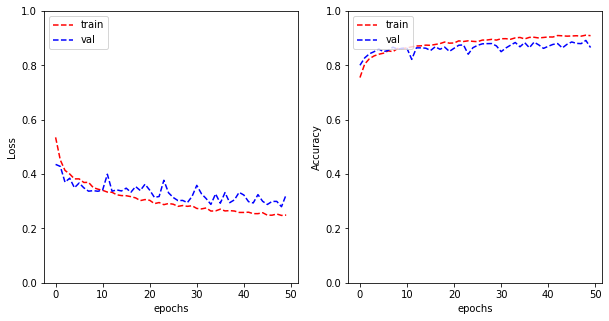

In [56]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['categorical_accuracy'], historyCancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# **Data Modelling**

* Lamda is tested with value of 0.00001 regularization.
* Built neural network using keras sequential.
* Activation function is set to `relu`.
* As the dataset have images in 27x27 RGB grid matrix so the `input_shape` is set to 27, 27, 3.
* We have created neural network with one hidden layer, one input layer and one output layer.
* The output layer activation function is set to `softmax`.
* Neurons of hidden layer is set to 54.
* Dropout rate is set to 0.2 that helps during back propogation.

In [57]:
reg_lambda = 0.00001

modelCancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same',  
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

Class weight is set to `balance`.

In [58]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes)
class_weights = dict(enumerate(class_weights))

In [61]:
modelCancerous.compile(tf.keras.optimizers.Adam(learning_rate=0.00001,name="Adam"),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [62]:
historyCancerous = modelCancerous.fit(train_generator, validation_data = validation_generator,callbacks=[early_stopping], epochs=50)

Epoch 1/50
451/451 [==============================] - 18s 38ms/step - loss: 0.6457 - categorical_accuracy: 0.6458 - val_loss: 0.6186 - val_categorical_accuracy: 0.6573
Epoch 2/50
451/451 [==============================] - 17s 39ms/step - loss: 0.5778 - categorical_accuracy: 0.6998 - val_loss: 0.5785 - val_categorical_accuracy: 0.6839
Epoch 3/50
451/451 [==============================] - 17s 38ms/step - loss: 0.4892 - categorical_accuracy: 0.7778 - val_loss: 0.6067 - val_categorical_accuracy: 0.7054
Epoch 4/50
451/451 [==============================] - 17s 38ms/step - loss: 0.4581 - categorical_accuracy: 0.7888 - val_loss: 0.4652 - val_categorical_accuracy: 0.7650
Epoch 5/50
451/451 [==============================] - 17s 37ms/step - loss: 0.4425 - categorical_accuracy: 0.7940 - val_loss: 0.4812 - val_categorical_accuracy: 0.7591
Epoch 6/50
451/451 [==============================] - 17s 38ms/step - loss: 0.4310 - categorical_accuracy: 0.7990 - val_loss: 0.4240 - val_categorical_accuracy:

In [ ]:
modelCancerous.optimizer.get_config()

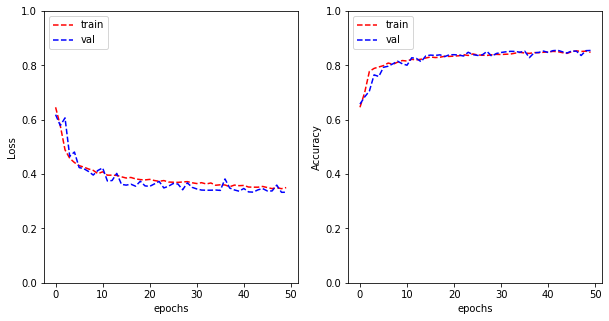

In [63]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['categorical_accuracy'], historyCancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [64]:
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 1
                                                                       
for x,y in test_generator:
        y_hat = modelCancerous.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
cf = confusion_matrix(y_all, y_hat_all)
# print("Confusion Matrix ", confusion_matrix(y_all, y_hat_all))
print("Classification Report")
print(classification_report(y_all, y_hat_all))

Accuracy score:  0.855980271270037
F1 score:  0.838881305082384
Classification Report
              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      2624
         1.0       0.83      0.75      0.79      1431

    accuracy                           0.86      4055
   macro avg       0.85      0.83      0.84      4055
weighted avg       0.85      0.86      0.85      4055



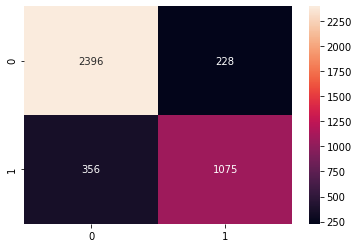

In [65]:
sns.heatmap(cf, annot=True,fmt='g')

In [66]:
modelCancerous.save("modelCancerous")

INFO:tensorflow:Assets written to: modelCancerous/assets


In [67]:
## Only on colab
# Change according to your directory structure
!cp -R ./modelCancerous/content/drive/'My Drive'/'Colab Notebooks'      

cp: missing destination file operand after './modelCancerous/content/drive/My Drive/Colab Notebooks'
Try 'cp --help' for more information.


In [68]:
modelCancerous.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 27, 27, 27)        756       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 27)        6588      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 27)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 54)        13176     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 54)        26298     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 54)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 108)        

In [69]:
modelCelltype = keras.models.load_model('/content/modelCancerous')

In [70]:
modelCelltype.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 27, 27, 27)        756       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 27)        6588      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 27)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 54)        13176     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 54)        26298     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 54)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 108)        

In [71]:
modelCelltype.pop()

In [72]:
modelCelltype.add(Dense(4, activation='softmax'))

In [73]:
modelCelltype.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 27, 27, 27)        756       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 27)        6588      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 27)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 54)        13176     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 54)        26298     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 54)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 108)        

In [74]:
data = pd.read_csv('./data_labels_mainData.csv')

OUTPUT_CLASSES = 4

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [75]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')
test_data['Class'] = test_data['cellType'].astype('str')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [76]:
modelCelltype.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="adam"),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [77]:
early_stopping = tf.keras.callbacks.EarlyStopping(
 monitor='val_sparse_categorical_accuracy', 
 verbose=1,
 patience=20,
 mode='max',
 restore_best_weights=True)

In [78]:
class_weight = {0: 1.,1: 2.,2: 2., 3: 1.}

In [80]:
#class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

AttributeError: ignored

In [81]:
modelCelltype.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.0001,
 'name': 'adam'}

In [82]:
historyCancerous = modelCelltype.fit(train_generator, validation_data = validation_generator, callbacks=[early_stopping], epochs=50)

Epoch 1/50
220/220 [==============================] - 9s 39ms/step - loss: 1.0110 - sparse_categorical_accuracy: 0.5752 - val_loss: 0.9151 - val_sparse_categorical_accuracy: 0.6427
Epoch 2/50
220/220 [==============================] - 8s 37ms/step - loss: 0.9063 - sparse_categorical_accuracy: 0.6473 - val_loss: 0.8703 - val_sparse_categorical_accuracy: 0.6246
Epoch 3/50
220/220 [==============================] - 8s 37ms/step - loss: 0.8428 - sparse_categorical_accuracy: 0.6712 - val_loss: 0.8778 - val_sparse_categorical_accuracy: 0.6331
Epoch 4/50
220/220 [==============================] - 8s 37ms/step - loss: 0.8187 - sparse_categorical_accuracy: 0.6889 - val_loss: 1.0181 - val_sparse_categorical_accuracy: 0.5760
Epoch 5/50
220/220 [==============================] - 8s 36ms/step - loss: 0.7991 - sparse_categorical_accuracy: 0.6918 - val_loss: 0.8106 - val_sparse_categorical_accuracy: 0.6705
Epoch 6/50
220/220 [==============================] - 8s 38ms/step - loss: 0.7724 - sparse_cate

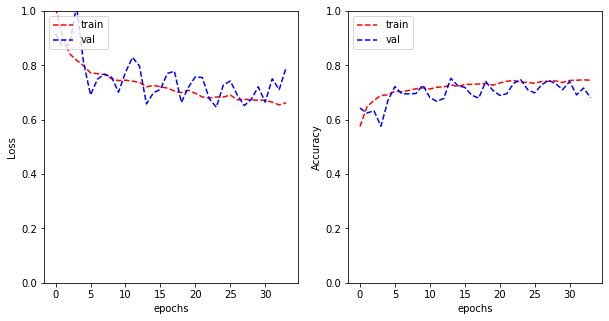

In [83]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['sparse_categorical_accuracy'], historyCancerous.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [84]:
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 1

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = modelCelltype.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
cf = confusion_matrix(y_all, y_hat_all)
print("Classicification Report")
print(classification_report(y_all, y_hat_all))

Accuracy score:  0.7331985851440121
F1 score:  0.66084335906588
Classicification Report
              precision    recall  f1-score   support

         0.0       0.65      0.71      0.68       391
         1.0       0.67      0.77      0.72       496
         2.0       0.86      0.89      0.88       790
         3.0       0.52      0.28      0.37       302

    accuracy                           0.73      1979
   macro avg       0.68      0.66      0.66      1979
weighted avg       0.72      0.73      0.72      1979



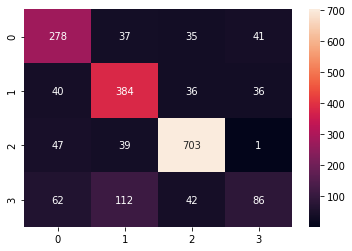

In [85]:
sns.heatmap(cf, annot=True,fmt='g')